In [22]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-

import scipy
import numpy as np
import pandas as pd
import soundfile
from scipy import io
from scipy.io import wavfile
from matplotlib.pyplot import specgram
import librosa
import librosa.display
import IPython.display as ipd
from matplotlib import pyplot as plt
import os
import glob

## Intro

Pour déterminer le genre de musique d'un morceau de musique, un certain nombre de variables basées sur le contenu sont d'abord extraites. En général, les fonctionnalités utilisées pour la classification de la musique peuvent être grossièrement classées en trois classes: la texture timbrale, les caractéristiques rythmiques et les caractéristiques de contenu de hauteur(pitch).

Les caractéristiques du timbre sont généralement caractérisées par les propriétés liées aux instrumentations ou aux sources sonores telles que la musique, la parole ou les signaux d'environnement. Les variables utilisées pour représenter la texture timbrale d'une piste musicale comprennent le zero crossing(le nombre de fois qu'un signal à traversé la barre horizontale à zéro), le centroïde spectral, le flux spectral, spectral rolloff, les coefficients cepstraux de fréquence Mel (MFCCs), etc.

## Chapitre
0. Chargement des données
1. Exploration
2. Extraction des features
3. Data processing (red dim, stats desc)
4. Application de SVM
5. Résultats

## Construction de la base de données

In [7]:
# Extraction des labels et des noms de fichier puis les enregistrer dans un dictionnaire
labels = []
musics = []
dirs = '../data_in/*/*'
for i in glob.glob(dirs):
    if glob.glob(i)[0][-4:] == ".wav":
        musics.append(i,)
        labels.append([i][0].split("/")[3].split(".")[0])


## EDA 

In [71]:
sample = dict(zip(labels, musics))

In [72]:
sample

{'country': '../data_in/country/country.00034.wav',
 'jazz': '../data_in/jazz/jazz.00049.wav',
 'hiphop': '../data_in/hiphop/hiphop.00031.wav',
 'disco': '../data_in/disco/disco.00081.wav',
 'blues': '../data_in/blues/blues.00042.wav',
 'metal': '../data_in/metal/metal.00038.wav',
 'classical': '../data_in/classical/classical.00096.wav',
 'pop': '../data_in/pop/pop.00088.wav',
 'rock': '../data_in/rock/rock.00030.wav',
 'reggae': '../data_in/reggae/reggae.00022.wav'}

In [96]:
import random
_, value = random.choice(list(sample.items()))
ipd.Audio(value)

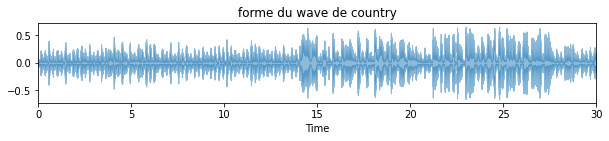

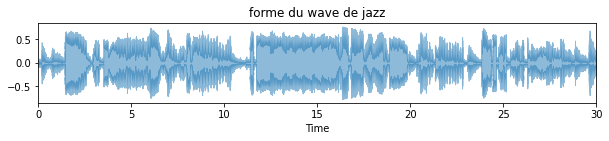

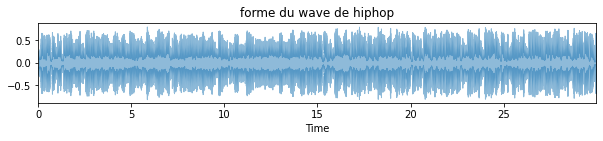

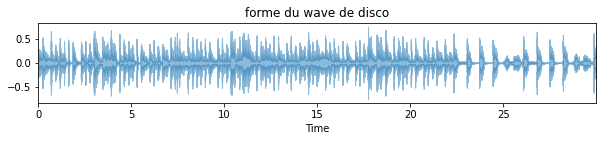

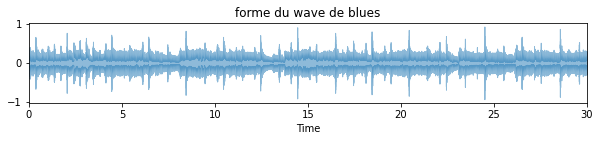

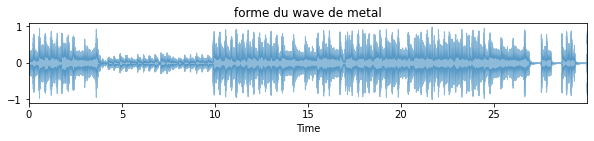

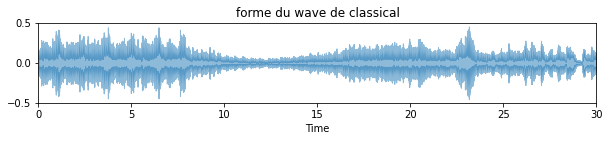

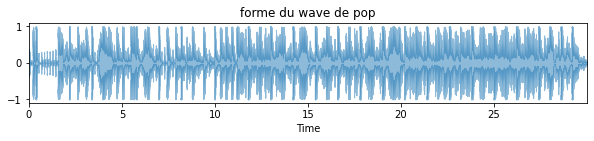

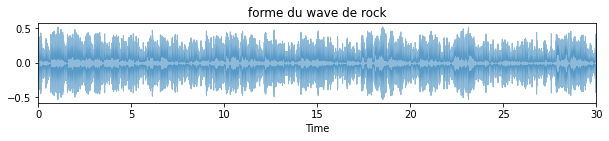

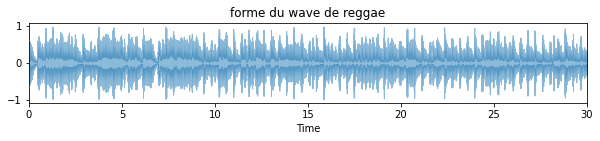

In [89]:
for label, audio in sample.items():
    plt.figure(figsize=(10,5))
    plt.subplot(3, 1, 1)
    librosa.display.waveplot(librosa.load(audio)[0], alpha=0.5)
    plt.title("forme du wave de "+label)

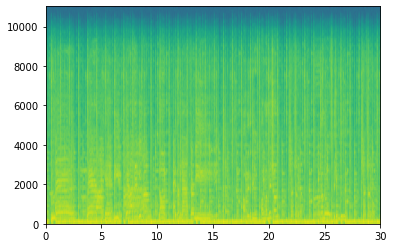

In [77]:
for label, audio in sample.items(): # a revoir
    sample_rate, X = wavfile.read(audio)
    spectro = specgram(X, Fs=sample_rate, xextent=(0,30))

## Features extraction

initialement: zero_crossing rate, mfccs, rootmeansq, amplitude envel

In [55]:
def getfeature(file_name):
    """
    input: le fichier audio
    output: feautures 
    """
    
    result = np.array([])
    X, sample_rate = librosa.load(file_name)
    stft = np.abs(librosa.stft(X))
    mfccs = np.mean(librosa.feature.mfcc(y=X, sr=sample_rate, n_mfcc=13, ).T, axis=0)
    result = np.hstack((result, mfccs))      
    chroma = np.mean(librosa.feature.chroma_stft(S=stft, sr=sample_rate).T,axis=0)
    result = np.hstack((result, chroma))
    zcr = np.mean(librosa.feature.zero_crossing_rate(y=X).T,axis=0)
    
    return  mfccs, chroma, zcr, result

In [56]:
#test
a, b, c, _ = getfeature("../data_in/country/country.00006.wav")

In [64]:
def parse_audio_files(*musicspaths):
    """
    
    """
    features, labels = np.empty((0, 26)), np.empty(0)
    # labels = []
    for filename in musics:
        try:
            mfccs, chroma, zcr = getfeature(filename)
        except Exception as e:
            print("Probleme avec le fichier: ", filename)
            continue
        ext_features = np.hstack([mfccs, chroma, zcr])
        features = np.vstack([features, ext_features])
        labels = np.append(labels, [filename][0].split("/")[3].split(".")[0])

    return np.array(features), np.array(labels)


In [65]:
# run
tr_features, tr_labels = parse_audio_files(musics)

In [68]:
# Concate feature et les labels
features = np.array(tr_features, dtype=pd.Series) 
labels_ = np.array(tr_labels, dtype=pd.Series)
run_df = pd.concat([pd.DataFrame(features), pd.DataFrame(labels_, columns=['labels'])], axis =1)
run_df.to_csv('../data_out/extrcated_feature.csv')


In [85]:
run_df.shape  # sanity check normalement 1000 lignes, 27 vars (13mfccs, 13chrma, 1zcr)

(1000, 27)

In [84]:
run_df.sample(3)

,0,1,2,3,4,5,6,7,8,9,...,17,18,19,20,21,22,23,24,25,labels
664,-321.13,134.604,-18.2553,22.1968,0.421831,-3.79939,0.484667,-1.14447,-1.89779,-0.100733,...,0.406403,0.432498,0.286528,0.384931,0.370004,0.657775,0.453658,0.329914,0.0708378,classical
242,-76.7762,98.3795,-5.03351,49.3443,-10.2783,33.2856,-9.96406,17.599,-12.2276,18.652,...,0.636659,0.670012,0.716606,0.715981,0.711391,0.755694,0.694168,0.671103,0.0803746,hiphop
621,-287.585,101.764,-35.3543,41.2878,-12.7332,17.2787,-13.9673,16.304,-5.59136,13.658,...,0.563045,0.704535,0.390489,0.47642,0.363692,0.703075,0.474446,0.339229,0.123423,classical
